In [2]:
# === Notebook 03 : Application Investisseur ===
# Cellule 1 : Introduction & Import des données

import pandas as pd
import os

# Répertoire des outputs
OUT_DIR_CLEAN = "outputs/clean"

# --- Introduction ---
print("📊 Analyse de données foncières pour investisseur immobilier")
print("-----------------------------------------------------------")
print("""
Persona cible : Investisseur locatif (Occitanie + Nouvelle-Aquitaine)

Objectif : Identifier les communes offrant les meilleures opportunités
d’investissement locatif, en combinant rendement (rentabilité) et fiabilité
(nombre de ventes observées).

Ce notebook fournit :
- Un tableau des communes les plus attractives,
- Des visualisations pour explorer la rentabilité et le marché,
- Des recommandations finales à l’attention de l’investisseur.
""")

# --- Import des données ---
communes_all_path = os.path.join(OUT_DIR_CLEAN, "communes_all.csv")
communes_all = pd.read_csv(communes_all_path)


📊 Analyse de données foncières pour investisseur immobilier
-----------------------------------------------------------

Persona cible : Investisseur locatif (Occitanie + Nouvelle-Aquitaine)

Objectif : Identifier les communes offrant les meilleures opportunités
d’investissement locatif, en combinant rendement (rentabilité) et fiabilité
(nombre de ventes observées).

Ce notebook fournit :
- Un tableau des communes les plus attractives,
- Des visualisations pour explorer la rentabilité et le marché,
- Des recommandations finales à l’attention de l’investisseur.



In [4]:
# === Cellule 2 : Fusion avec loyers pour ajout du nom des communes (LIBGEO) ===

# Charger loyers
loyers_path = "Loyer/loyers_filtre_occitanie_nouvelle_aquitaine.csv"
loyers = pd.read_csv(loyers_path, sep=";", encoding="utf-8")

# Nettoyage rapide de la colonne loyer si besoin
if loyers["loypredm2"].dtype == "object":
    loyers["loypredm2"] = (
        loyers["loypredm2"]
        .str.replace(",", ".", regex=False)
        .str.replace(" ", "", regex=False)
        .astype(float)
    )

# Fusion communes_all + LIBGEO depuis loyers
communes_named = communes_all.merge(
    loyers[["INSEE_C", "LIBGEO"]],
    on="INSEE_C",
    how="left"
)

# Supprimer doublons éventuels (au cas où plusieurs LIBGEO pour même INSEE_C)
communes_named = communes_named.drop_duplicates(subset=["DEP", "INSEE_C"])


In [5]:
# === Cellule 3 : Score d'attractivité (rentabilité × fiabilité) ===

import numpy as np

# On enlève les lignes sans données utiles
df_valid = communes_named.dropna(subset=["rentabilite_m2_moy", "nb_ventes"])

# Construire un score combinant rentabilité et fiabilité :
# - rentabilité brute moyenne (%)
# - nb_ventes : plus il y a eu de ventes, plus le score est fiable
# - log(1 + nb_ventes) permet de pondérer sans que les très gros volumes écrasent tout
df_valid["score_interet"] = (
    df_valid["rentabilite_m2_moy"] * np.log1p(df_valid["nb_ventes"])
)

# Trier les communes selon ce score
top20_interessantes = df_valid.sort_values("score_interet", ascending=False).head(20)

print("🔝 Top 20 communes les plus intéressantes (rentabilité × fiabilité)")
display(top20_interessantes[[
    "DEP", "INSEE_C", "LIBGEO", "rentabilite_m2_moy",
    "nb_ventes", "prix_m2_moy", "loyer_m2_moy", "score_interet"
]])


🔝 Top 20 communes les plus intéressantes (rentabilité × fiabilité)


,DEP,INSEE_C,LIBGEO,rentabilite_m2_moy,nb_ventes,prix_m2_moy,loyer_m2_moy,score_interet
28420,66,66136,Perpignan,9.424446,20325,1719.4943,11.178081,93.487264
7224,19,19272,Tulle,12.723861,1390,994.6512,8.746646,92.092484
33248,87,87085,Limoges,8.995930,17593,1599.0114,10.472053,87.938033
30448,81,81163,Mazamet,12.183833,1342,1051.1700,8.701145,87.756021
27732,65,65440,Tarbes,9.759357,6807,1392.8982,9.940677,86.134652
2916,16,16015,Angoulême,9.606109,6658,1519.8925,10.434404,84.569538
29360,79,79191,Niort,9.031596,10381,1694.0214,11.049280,83.522654
268,11,11069,Carcassonne,9.490041,6628,1397.7501,9.596110,83.504856
18164,34,34032,Béziers,8.777136,12820,1795.7607,10.427434,83.021523
8436,24,24037,Bergerac,9.633956,4877,1513.1292,10.305896,81.816281


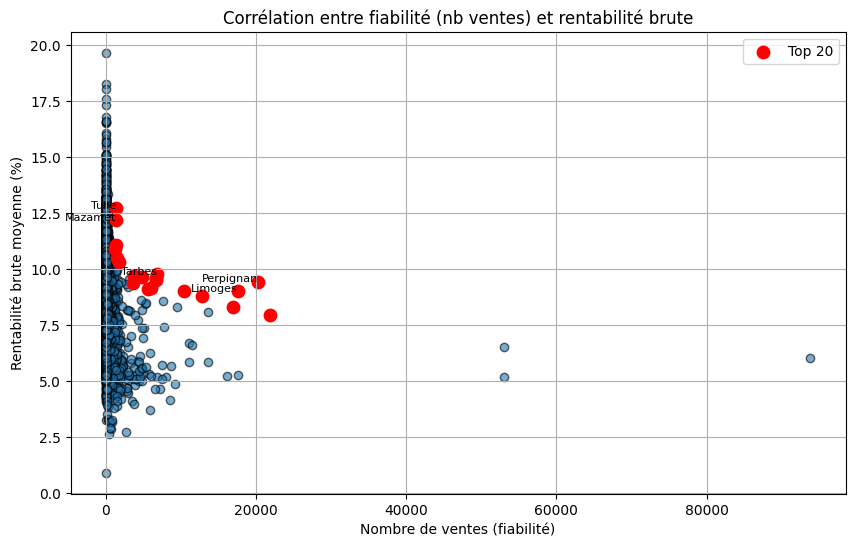

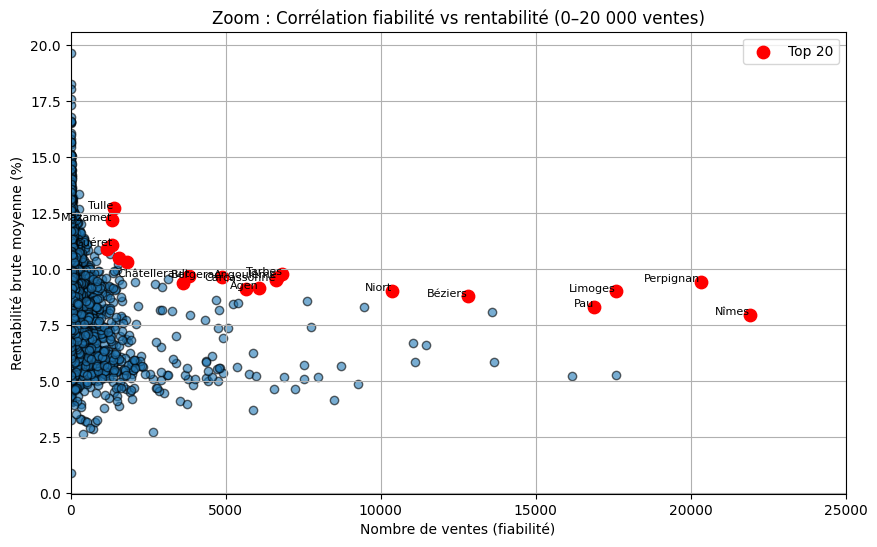

In [27]:
# === Cellule 4 : Visualisation attractivité communes ===

import matplotlib.pyplot as plt

# --- Graphe global ---
plt.figure(figsize=(10,6))

plt.scatter(
    df_valid["nb_ventes"],
    df_valid["rentabilite_m2_moy"],
    alpha=0.6, edgecolor="k"
)

top20 = df_valid.sort_values("score_interet", ascending=False).head(20)
plt.scatter(
    top20["nb_ventes"],
    top20["rentabilite_m2_moy"],
    color="red", s=80, label="Top 20"
)

for _, row in top20.head(5).iterrows():
    plt.text(
        row["nb_ventes"], row["rentabilite_m2_moy"],
        row["LIBGEO"],
        fontsize=8, ha="right"
    )

plt.title("Corrélation entre fiabilité (nb ventes) et rentabilité brute")
plt.xlabel("Nombre de ventes (fiabilité)")
plt.ylabel("Rentabilité brute moyenne (%)")
plt.legend()
plt.grid(True)
plt.show()


# --- Graphe zoomé (0 à 20 000 ventes) ---
plt.figure(figsize=(10,6))

plt.scatter(
    df_valid["nb_ventes"],
    df_valid["rentabilite_m2_moy"],
    alpha=0.6, edgecolor="k"
)

plt.scatter(
    top20["nb_ventes"],
    top20["rentabilite_m2_moy"],
    color="red", s=80, label="Top 20"
)

for _, row in top20.head(15).iterrows():
    plt.text(
        row["nb_ventes"], row["rentabilite_m2_moy"],
        row["LIBGEO"],
        fontsize=8, ha="right"
    )

plt.xlim(0, 25000)  # ⚡ zoom sur nb_ventes entre 0 et 20 000
plt.title("Zoom : Corrélation fiabilité vs rentabilité (0–20 000 ventes)")
plt.xlabel("Nombre de ventes (fiabilité)")
plt.ylabel("Rentabilité brute moyenne (%)")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
# === Cellule 5 : Carte interactive des 20 communes les plus intéressantes ===

import folium
from folium.plugins import MarkerCluster
import requests

# ⚡ Sélection des top 20 communes (score_interet)
top20 = df_valid.sort_values("score_interet", ascending=False).head(20)

# Créer une carte centrée sur le barycentre des top20
map_center = [46.5, 2.5]  # France métropolitaine
m = folium.Map(location=map_center, zoom_start=6)

# Cluster pour éviter les overlaps
marker_cluster = MarkerCluster().add_to(m)

# Ajouter les points
for _, row in top20.iterrows():
    insee_code = row["INSEE_C"]

    # --- Géocodage via API BAN (Base Adresse Nationale) ---
    try:
        url = f"https://api-adresse.data.gouv.fr/search/?q={row['LIBGEO']}&type=municipality&autocomplete=0"
        r = requests.get(url).json()
        if r["features"]:
            coords = r["features"][0]["geometry"]["coordinates"][::-1]  # [lat, lon]
        else:
            coords = None
    except Exception:
        coords = None

    if coords:
        popup = folium.Popup(
            f"<b>{row['LIBGEO']}</b><br>"
            f"INSEE: {insee_code}<br>"
            f"Rentabilité: {row['rentabilite_m2_moy']:.2f}%<br>"
            f"Nb ventes: {row['nb_ventes']}",
            max_width=300
        )
        folium.Marker(
            location=coords,
            popup=popup,
            icon=folium.Icon(color="red", icon="home", prefix="fa")
        ).add_to(marker_cluster)

m


In [ ]:
# === Cellule 6 : Widget interactif (auto-update sans bouton) ===

import ipywidgets as widgets
from IPython.display import display, clear_output

def explore_commune_auto(nom_commune, code_insee):
    clear_output(wait=True)
    print(f"DEBUG -> nom_commune: {nom_commune}, code_insee: {code_insee}")

    if code_insee:
        subset = df_valid[df_valid["INSEE_C"].astype(str) == str(code_insee)]
    elif nom_commune:
        subset = df_valid[df_valid["LIBGEO"].str.upper() == nom_commune.upper()]
    else:
        print("⚠️ Merci de donner un nom de commune ou un code INSEE")
        return

    if subset.empty:
        print("❌ Aucune commune trouvée avec ces critères")
    else:
        print("✅ Commune trouvée :")
        display(subset[[
            "DEP", "INSEE_C", "LIBGEO",
            "nb_ventes", "prix_m2_moy", "loyer_m2_moy", "rentabilite_m2_moy", "score_interet"
        ]])

# Widgets liés
commune_name = widgets.Text(value="", placeholder="Ex: Toulouse", description="Commune :")
commune_insee = widgets.Text(value="", placeholder="Ex: 31555", description="INSEE :")

ui = widgets.HBox([commune_name, commune_insee])
out = widgets.interactive_output(
    explore_commune_auto,
    {"nom_commune": commune_name, "code_insee": commune_insee}
)

display(ui, out)


Output()

In [19]:
# === Cellule : Filtre dynamique interactif (sans type de bien) ===
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt

# Widgets
dep_dropdown = widgets.Dropdown(
    options=["Tous"] + sorted(communes_all["DEP"].unique().tolist()),
    value="Tous",
    description="Département:"
)

nb_ventes_slider = widgets.IntSlider(
    value=5, min=0, max=int(communes_all["nb_ventes"].max()), step=1,
    description="Nb ventes ≥"
)

rentabilite_slider = widgets.FloatSlider(
    value=5.0, min=0, max=20, step=0.5,
    description="Rentabilité ≥ (%)"
)

@interact(
    dep=dep_dropdown,
    min_ventes=nb_ventes_slider,
    min_renta=rentabilite_slider
)
def explore_filtre(dep, min_ventes, min_renta):
    # Filtrage
    df = communes_all.copy()
    if dep != "Tous":
        df = df[df["DEP"] == dep]
    df = df[(df["nb_ventes"] >= min_ventes) & (df["rentabilite_m2_moy"] >= min_renta)]

    # Affichage tableau top 20
    display(df.sort_values("rentabilite_m2_moy", ascending=False).head(20))

    # Graphique scatter : rentabilité vs nb ventes
    if not df.empty:
        plt.figure(figsize=(8,5))
        plt.scatter(df["nb_ventes"], df["rentabilite_m2_moy"], alpha=0.7)
        plt.xlabel("Nb ventes")
        plt.ylabel("Rentabilité brute (%)")
        plt.title("Communes filtrées : Nb ventes vs Rentabilité")
        plt.show()
    else:
        print("⚠️ Aucun résultat avec ces filtres")


interactive(children=(Dropdown(description='Département:', options=('Tous', 11, 12, 16, 17, 19, 23, 24, 30, 31…